# Laboratoire 4 - Odométrie

> **Attention!** Il est *strictement interdit* de s'approcher des commandes qui font avancer le robot si il y a le moindre risque que le robot ne tombe par terre. Les équipes qui ont un accidents de robot devront chanter *Never Gonna Give You Up* devant toute la classe.

Au cours de ce laboratoire nous allons étudier la façon dont le robot se déplace. Comme vous le constaterez, le sujet est plus complexe qu'il n'y paraît! Connectons-nous d'abord au robot.


In [1]:
%matplotlib inline

from robmob import robot, sensors
from time import sleep
from math import pi as PI

import numpy as np
import matplotlib.pyplot as plt

robot_ip = '192.168.0.105'
robot = robot.Robot(robot_ip)
robot.connect()

## Partie 1 - Le problème du contrôle

Pour cette première expérience, utilisez les fonctions de la librairie `robmob` pour ordonner au robot d'avancer de un mètre.

In [ ]:
robot.linear_movement(0.2, 5)  # Ordonne au robot d'avancer à 0.2 m/s pendant 5 s

Vous constaterez que les kobukis se déplacent de beaucoup moins qu'un mètre avec l'exécution de cette command. Qu'est-ce qui se passe? Pour le comprendre, il faut d'abord se demander comment le robot exécute notre demande.

Nous envoyons une commande de vitesse au robot. Le robot active ses moteurs, puis après un certain $\Delta t$ le robot consulte les encodeurs de ses roues pour valider sa vitesse. La différence entre la vitesse demandée et la vitesse réelle constitue une erreur. Cette erreur est fournie à une fonction appelée un [correcteur PID](https://fr.wikipedia.org/wiki/R%C3%A9gulateur_PID) qui traduit l'erreur en une nouvelle consigne. Cette nouvelle consigne tente de corriger l'erreur sur la vitesse du robot, pour exécuter aussi bien que possible la commande qu'on lui a demandé.

Malheureusement, il est difficile de créer un correcteur parfait. Dans le cas qui nous concerne, le correcteur semble avoir de la difficulté à atteindre la vitesse demandée, surtout au début de la trajectoire. Voici un graphique de la vitesse instantanée d'un robot kobuki par rapport au temps. La vitesse demandée est en rouge. L'apparence de ce graphique explique pourquoi les distances parcourues par le robot sont plus courtes que les distances demandées.

![Vitesse de la kobuki par rapport au temps](img/vitesse_kobuki.png)



## Partie 2 - Rotation

Dans cette section nous effectuerons des rotations et nous validerons comment le robot peut déduire son état à l'aide de ses différents senseurs.


En premier lieu, fixez une règle sur le robot et placez une feuille de papier de façon à pouvoir facilement calculer des angles, comme sur l'image.

![Montage rotation](img/montage_rotation.png)

Maintenant demandons au robot de faire une rotation de $\pi$ radians. 

In [ ]:
robot.angular_movement(PI / 4, 4) # Demande au robot de tourner à PI/4 radians/seconde pendant 4 secondes.

Mesurez la rotation que le robot a effectué. Vous constaterez que la rotation résultante est beaucoup plus faible que la rotation demandée.  Mais le robot en est-il conscient?

### Odométrie

Nous allons utiliser l'odomètre du robot pour estimer sa rotation réelle. Pour ce faire nous pouvons ajouter un `OdometerTicksSensor` à notre objet `robot`.

In [ ]:
odometer = sensors.OdometerTicksSensor()
robot.add_sensor(odometer)
sleep(1)
odometer.peek_data()

L'odomètre nous renvoie trois valeurs: le *timestamp* du message, le nombre de ticks enregistrés pour la roue gauche, et le nombre de ticks enregistrés par la roue droite. Il est possible de convertir ces ticks en distance parcourue! Sachant que la variable `odometer.TICK_TO_METER` indique le déplacement d'une roue lorsqu'elle effectue un tick, le déplacement de la roue gauche depuis que le robot est activé est comme suit.

In [ ]:
message = odometer.peek_data()
displacement = message[1] * odometer.TICK_TO_METER

Le code suivant demande au robot de faire une rotation de $\pi$ radians, et enregistre le status de l'odomètre avant et après le déplacement. Sachant cela, calculez le déplacement subi par la roue gauche et la roue droite.

In [ ]:
odometer_before = odometer.peek_data()
robot.angular_movement(PI / 4, 4)
sleep(1)
odometer_after = odometer.peek_data()

In [ ]:
displacement_right = (odometer_after[2] - odometer_before[2]) * odometer.TICK_TO_METER
displacement_left = (odometer_after[1] - odometer_before[1]) * odometer.TICK_TO_METER

print('Left (m): {}, Right (m): {}'.format(displacement_left, displacement_right))

À l'aide de ces déplacements, calculez la rotation que le robot a effectué, du point de vue de l'odomètre. La valeur `robot.DISTANCE_CENTER_TO_WHEEL` pourrait vous être utile.

In [ ]:
rotation = (displacement_right - displacement_left) / (2*robot.DISTANCE_CENTER_TO_WHEEL)

print('Rotation (rad): {}, Rotation (deg): {}'.format(rotation, rotation / (2*PI) * 360))

### Gyroscope

Vous êtes déjà à l'aise avec le gyroscope. Nous allons intégrer ses mesures pour faire un nouvel estimé de la rotation. Mais d'abord, trouvons rapidement un biais. Pour ce faire, laissez le robot immobile pendant que vous exécutez le code suivant.

In [ ]:
gyro = sensors.GyroSensor(6 * sensors.GyroSensor.SAMPLE_RATE) # Le buffer a une durée de 6 secondes.
robot.add_sensor(gyro)

sleep(7)

gyro_data = gyro.read_buffer() # La commande read_buffer capture tout le contenu du buffer. Le buffer est vide après.
gyro_data = np.array([x[2] for x in data]) # On a seulement besoin de la vitesse angulaire autour de l'axe z.
bias = np.mean(gyro_data)

print('Bias (deg/s): {}'.format(bias))

Avec un peu de chance, le routeur va bien se comporter et vous recevez les mesures du gyro en temps réel. Si c'est le cas, exécutez du code de façon à intégrer le déplacement angulaire du robot alors qu'il exécute la même commande.

In [ ]:
robot.angular_movement(PI/4, 4)
sleep(1)

gyro_data = gyro.read_buffer()  # Le buffer contient seulement les 6 dernières secondes.
gyro_data = [x[2] for x in gyro_data]

rotation = 0.0
for reading in gyro_data:
    rotation += (reading - bias) * (1.0 / gyro.SAMPLE_RATE)
    
print('Rotation (rad): {}, Rotation (deg): {}'.format(rotation * 2 * PI / 360, rotation))

## Partie 3 - Variance sur le déplacement

Une autre conséquence de ces contrôleurs imparfaits, c'est que le déplacement du robot ne sera pas tout à fait constant pour une commande donnée. Il est habituel de modéliser ce phénomène avec une distribution gaussienne. On ne s'attend jamais à ce que le robot se déplace de $x$ radians, on s'attend plutôt qu'il se déplace en moyenne de $x$ radians avec une certaine variance.

Codez une boucle qui demande au robot de faire une grande quantité (autour de 20) de petites rotations. À chaque rotation, calculez le déplacement angulaire du point de vue de l'odomètre. Finalement, calculez l'écart type de la distribution ainsi calculée. La fonction `np.var` calcule la variance d'une liste.

In [ ]:
def angle_from_odom_values(before, after):
    displacement_left = (after[1] - before[1]) * odometer.TICK_TO_METER
    displacement_right = (after[2] - before[2]) * odometer.TICK_TO_METER
    
    return (displacement_right - displacement_left) / (2 * robot.DISTANCE_CENTER_TO_WHEEL)

odom_measurements = []

for _ in range(20):
    odom_before = odometer.peek_data()
    robot.angular_movement(PI / 1.5, 0.8)
    sleep(1)
    odom_after = odometer.peek_data()
    odom_measurements.append(angle_from_odom_values(odom_before, odom_after))

In [ ]:
odom_measurements = np.array(odom_measurements)
print('Measurements: ' + str(odom_measurements))
print('Standard deviation (rad): {}'.format(np.sqrt(np.var(odom_measurements))))

## Intermède - Les listes et numpy

Pour bien comprendre la partie 4, il faut comprendre que `numpy` (de façon similaire à matlab) permet de faire facilement des opérations sur des listes. Prenez bien le temps de comprendre les sorties suivantes avant de continuer.

In [ ]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([5, 4, 3, 2, 1])

print(a+b)
print(a*b)
print(a + 3)
print(a * 2)

## Partie 4 - Intégration

Vous avez maintenant tous les outils qu'il vous faut pour estimer la position du robot dans un repère global à travers le temps. Pour ce faire il suffit d'intégrer la vitesse du robot à travers le temps. 

Commençons par collecter des données. Débutez l'exécution du code suivant. Il s'assure que le buffer de l'odométrie a une durée d'une minute. Ensuite, utilisez le fichier [Controller.ipynb](Controller.ipynb) pour conduire le robot sur une trajectoire de votre choix. Déplacez le robot pendant un peu moins d'une minute, de sorte que toutes les donnez nécessaires se trouveront dans le buffer. Après `duration_of_data_collection` secondes les données du buffer seront capturées et vous pourrez les analyser.

> N'hésitez pas à utiliser la commande `plt.plot()` sur n'importe quelle liste dans votre code pour aider le debugging.

In [2]:
duration_of_data_collection = 30

odometer = sensors.OdometerTicksSensor(sensors.OdometerTicksSensor.SAMPLE_RATE*duration_of_data_collection)
robot.add_sensor(odometer)

sleep(duration_of_data_collection)

odometry_data = odometer.read_buffer()

À partir de `odometry_data`, on doit créer quatre listes. Une liste doit contenir le temps écoulé depuis le début de la collecte de données. Une liste doit contenir le temps écoulé entre les mesures successives d'odométrie. Une autre liste doit contenir le nombre de ticks d'odomètre qui ont eu lieu pendant ce temps pour la roue gauche. Le dernier vecteur doit contenir la même chose, mais pour la roue droite. La fonction `np.diff()` vous sera très utile ici.

In [5]:
t = odometry_data[:,0] - odometry_data[0,0]
delta_t = np.diff(t)
displacement_left = np.diff(odometry_data[:,1]) * odometer.TICK_TO_METER
displacement_right = np.diff(odometry_data[:,2]) * odometer.TICK_TO_METER

On peut déduire la vitesse de chaque roue à travers le temps de la façon suivante.

In [6]:
right_wheel_speed = displacement_right / delta_t
left_wheel_speed = displacement_left / delta_t

En utilisant les équations de conduite différentielle vues en classe, on peut convertir les vitesses des roues en des vitesses linéaires et angulaires du robot, pour chaque temps $t$.

In [7]:
linear_speed = (right_wheel_speed + left_wheel_speed) / 2
angular_speed = (right_wheel_speed - left_wheel_speed) / (2 * robot.DISTANCE_CENTER_TO_WHEEL)

Finalement, convertissons ces vitesses en une position $\vec{x}(t)$ et une orientation $\vec{\theta}(t)$. Vous devrez *intégrer* les vitesses pour y arriver. 

> **PROTIP** Intégrez l'orientation d'abord! Vous en avez besoin pour calculer la position x y...

In [8]:
theta_of_t = np.cumsum(angular_speed * delta_t)
x_of_t = np.cumsum(linear_speed * np.cos(theta_of_t) * delta_t)
y_of_t = np.cumsum(linear_speed * np.sin(theta_of_t) * delta_t)

Affichez la trajectoire calculée avec les commandes suivante.

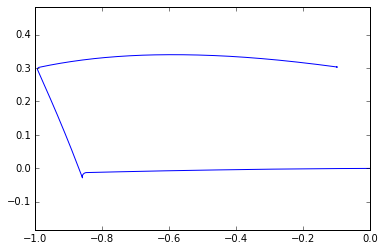

In [9]:
plt.plot(x_of_t, y_of_t)
plt.axis('equal') # On s'assure que l'échelle est la même sur les deux axes
plt.show()

Il serait intéressant de répéter la partie 4 avec une trajectoire qui *revient à son points d'origine*. Ainsi, vous pourrez constater que l'odométrie aussi souffre de dérive, comme le gyroscope.